In [150]:
#map TFs binding a promoter to their relevant coefficient of variation - see if they correspond to constitutive or variable
#Count TFs only once (only use unique TFs)
#this script will work for any promoter length

In [1]:
import pandas as pd
#import argparse
import os
import seaborn as sns
import matplotlib.pyplot as plt
from pybedtools import BedTool
import io
#stats
from pingouin import kruskal
import scikit_posthocs as sp
from scipy import stats

/home/witham/opt/anaconda3/envs/PromoterArchitecturePipeline/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.7, the latest is 0.3.8.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
# parser = argparse.ArgumentParser(description='map_TF2CV')
# parser.add_argument('file_names', type=str, help='Name of folder and filenames for the promoters extracted')
# parser.add_argument('Czechowski_gene_categories', type=str, help='Input location of Czechowski gene categories text file')
# parser.add_argument('Czechowski_all_cvs', type=str, help='Input location of Czechowski coefficient of variations for all genes in the microarray')
# parser.add_argument('mapped_motif_bed', type=str, help='Input location of promoters mapped motif bed')
# parser.add_argument('output_folder_name', type=str, help='Optional output folder name ending in a forward slash',default = '')

In [3]:
dependent_variable = 'TFBS_TF_class'
file_names = 'non-overlapping_includingbidirectional_all_genes_newannotation'
Czechowski_gene_categories = f'../../data/output/{file_names}/genes/promoters_5UTR_czechowski_constitutive_variable_random.txt'
Czechowski_rankedcv = f'../../data/genes/AtGE_dev_gcRMA__all_probes__CV.tsv'
mapped_motif_bed = f'../../data/output/{file_names}/FIMO/promoters_5UTR_400bp_motifs_mapped.bed'
output_folder_name = 'promoters_5UTR_400bp/'
rootshootintersect_openchromatin = '../../data/ATAC-seq/potter2018/intersectRootsShoots_PeaksInBoth.bed'
root_openchromatin = '../../data/ATAC-seq/potter2018/Roots_NaOH_peaks_all.bed'
shoot_openchromatin = '../../data/ATAC-seq/potter2018/Shoots_NaOH_peaks_all.bed'
mapped_motif_bed_openchrom_rootshootintersect = f'../../data/output/{file_names}/FIMO/promoters_5UTR_400bp_motifs_mapped_openchromrootshootintersect.bed'
mapped_motif_bed_openchrom_root = f'../../data/output/{file_names}/FIMO/promoters_5UTR_400bp_motifs_mapped_openchromroot.bed'
mapped_motif_bed_openchrom_shoot = f'../../data/output/{file_names}/FIMO/promoters_5UTR_400bp_motifs_mapped_openchromshoot.bed'

In [4]:
#make directory for the plots to be exported to
dirName = f'../../data/output/{file_names}/{dependent_variable}'
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " created") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")

Directory  ../../data/output/non-overlapping_includingbidirectional_all_genes_newannotation/TFBS_TF_class  already exists


In [5]:
#make directory for the plots to be exported to
dirName = f'../../data/output/{file_names}/{dependent_variable}/{output_folder_name}'
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " created") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")

Directory  ../../data/output/non-overlapping_includingbidirectional_all_genes_newannotation/TFBS_TF_class/promoters_5UTR_400bp/  already exists


In [6]:
#make directory for the plots to be exported to
dirName = f'../../data/output/{file_names}/{dependent_variable}/{output_folder_name}plots'
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " created") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")

Directory  ../../data/output/non-overlapping_includingbidirectional_all_genes_newannotation/TFBS_TF_class/promoters_5UTR_400bp/plots  already exists


In [7]:
def intersectbed(mapped_motifs_file,openchrom_bed, output):
    """function to intersect motifs_mapped with open chromatin, dropping any TFs which do not fall within open chromatin"""
    #read in mapped motifs bed
    mapped_motifs = pd.read_table(mapped_motifs_file, sep='\t', header=None)
    #if whole promoter, mapped motif will have 13 columns
    #if shortened promoter, mapped motif file will have 24 (as bp overlap is needed in TF_diversity_plots_shortenedprom.py to remove TFBSs where the middle isn't in the promoter)
    #if 24 columns, only select the subset of 13 columns
    #if 13 columns, keep them all
    #This is to make the dfs have identical column names
    if len(mapped_motifs.columns) == 24:
        cols = ['chr', 'start', 'stop', 'promoter_AGI','dot1','strand','source','type','dot2','attributes',
            'motif_chr','motif_start','motif_stop','name_rep', 'score', 'motif_strand',
            'promoter_AGI2', 'p-value', 'q-value', 'matched_sequence', 'TF_name', 'TF_family', 'TF_AGI','bp_overlap']
        mapped_motifs.columns = cols
        #filter columns
        mapped_motifs = mapped_motifs[['motif_chr','motif_start','motif_stop','name_rep', 'score', 'motif_strand',
             'promoter_AGI2', 'p-value', 'q-value', 'matched_sequence', 'TF_name', 'TF_family', 'TF_AGI']]
        #rename columns
        cols = ['chr', 'start', 'stop', 'name_rep', 'score', 'strand', 'promoter_AGI', 'p-value', 'q-value', 'matched_sequence', 'TF_name', 'TF_family', 'TF_AGI']
        mapped_motifs.columns = cols
        
    else:
        cols = ['chr', 'start', 'stop', 'name_rep', 'score', 'strand', 'promoter_AGI', 'p-value', 'q-value', 'matched_sequence', 'TF_name', 'TF_family', 'TF_AGI']
        mapped_motifs.columns = cols
    #remove invalid lines
    mapped_motifs = mapped_motifs[mapped_motifs.chr != '.']
    #save mapped motifs as temporary file
    #save mapped motifs as a buffer
    tempbuffer = io.StringIO()
    #write df to buffer
    mapped_motifs.to_csv(tempbuffer, header=None, index=False,sep='\t')
    #go back to start of buffer
    tempbuffer.seek(0)
    #read in files as bedtool objects
    mapped_motifs2 = BedTool(tempbuffer)
    openchrom = BedTool(openchrom_bed)
    #run bedtools intersect
    #wo,  Write the original A and B entries plus the number of base pairs of overlap between the two features. Only A features with overlap are reported. 
    #f=1 means only include motif is 100% of it is in open chromatin
    intersect = mapped_motifs2.intersect(openchrom, wo=True, f=1).saveas(output) 
    #could add u=True which indicates we want to see the promoters that overlap features in the genome
    #remove buffer
    tempbuffer.close()

In [8]:
def map_cv(ranked_cvs_file,mapped_motifs_file):
    """function to map the CV value to the TFs which bind to each promoter"""
    #read in files
    cvs = pd.read_table(ranked_cvs_file, sep='\t', header=None)
    cols = ['rank','probe_id','TF_AGI','expression_mean','expression_SD','expression_CV','proportion_of_values_present_in_mas5','presence_in_araport11','constitutive_in_araport11']
    cvs.columns = cols
    #filter out any genes that aren't present in araport11
    cvs = cvs[cvs.presence_in_araport11==1]
    #read in mapped motifs
    mapped_motifs = pd.read_table(mapped_motifs_file, sep='\t', header=None)
    #if whole promoter, mapped motif will have 17 columns
    #if shortened promoter, mapped motif file openchrom will have 28 (as bp overlap is needed in TF_diversity_plots_shortenedprom.py to remove TFBSs where the middle isn't in the promoter)
    #if 28 columns, only select the subset of 13 columns
    #if 17 columns, keep them all
    #This is to make the dfs have identical column names

    cols = ['chr', 'start', 'stop', 'name_rep', 'score', 'strand', 'promoter_AGI', 'p-value', 'q-value', 'matched_sequence', 'TF_name', 'TF_family', 'TF_AGI','chr_chrom','start_chrom','stop_chrom','bp_overlap']
    mapped_motifs.columns = cols
    #filter unwanted columns
    mapped_motifs = mapped_motifs[['chr', 'start', 'stop', 'name_rep', 'score', 'strand', 'promoter_AGI', 'p-value', 'q-value', 'matched_sequence', 'TF_name', 'TF_family', 'TF_AGI']]
    #merge CV df with mapped_motifs, adding the CVs to the respective TF AGIs
    merged = pd.merge(mapped_motifs, cvs, how='left', on='TF_AGI')
    #Groupby promoter and then keep only unique TFs in each promoter
    #unique_CV_means = merged.groupby(['promoter_AGI', 'TF_AGI'])['expression_mean'].agg(lambda x: x.unique())
    unique_TFs = merged.drop_duplicates(['promoter_AGI', 'TF_AGI']).reset_index(drop=True)

   
    return merged,unique_TFs

In [9]:
def merge_genetype(df, gene_categories):
    """merge df with gene_categories file adding the genetype of the promoters (if in top 100 constitutive or top 100 variable promoters)"""
    gene_cats = pd.read_table(gene_categories, sep='\t', header=None)
    cols = ['promoter_AGI','gene_type']
    gene_cats.columns = cols
    merged = pd.merge(gene_cats,df, on='promoter_AGI', how='left')
    return merged

In [10]:
def calculate_mean_SD_CV(df):
    """calculate the mean coefficient of variation of the unique TFs binding to a promoter"""
    #group by promoter and calculate mean for each promoter
    means = df.groupby('promoter_AGI')['expression_CV'].mean()
    #turn into a dataframe
    means_df = pd.DataFrame(means)
    #turn the index into a new column
    means_df.reset_index(level=0, inplace=True)
    #name columns
    cols = ['promoter_AGI', 'mean_cv']
    means_df.columns = cols
    
        
    #group by promoter and calculate SD (standard deviation) for each promoter
    sd = df.groupby('promoter_AGI')['expression_CV'].std()
    #turn into a dataframe
    sd_df = pd.DataFrame(sd)
    #turn the index into a new column
    sd_df.reset_index(level=0, inplace=True)
    #name columns
    cols = ['promoter_AGI', 'sd']
    sd_df.columns = cols
    
    #merge the dfs
    merged = pd.merge(means_df,sd_df)   
    return merged

In [11]:
def all_prom_distribution(df, x_variable, x_label, output_prefix):
    """function to return distribution plot of all promoters GC content"""    
    
    dist_plot = df[x_variable]
    #create figure with no transparency
    dist_plot_fig = sns.distplot(dist_plot).get_figure()
    plt.xlabel(x_label)

    #save to file
    dist_plot_fig.savefig(f'../../data/output/{file_names}/{dependent_variable}/{output_folder_name}plots/{output_prefix}_distribution.pdf', format='pdf')

In [12]:
def make_plot(df,x_variable, y_variable,x_label, y_label, output_prefix, plot_kind):
    """function to make and save plot"""
    #allow colour codes in seaborn
    sns.set(color_codes=True)
    sns.set_style("whitegrid")
    #plot
    x=x_variable
    y=y_variable
    order=["constitutive", "variable", "control"]
    plot = sns.catplot(x=x, y=y, data=df, kind=plot_kind,order=order)
    #plot points
    ax = sns.swarmplot(x=x, y=y, data=df, color=".25",order=order)
    #add significance if necessary - dunn's posthocs with multiple Bonferroni correction
    stat = dunn_posthoc_test(df,y_variable,x_variable)
    #label box pairs
    box_pairs=[("constitutive", "variable"),("constitutive", "control"),("variable", "control")]
    #make empty list of p_values
    p_values = []
    #populate the list of p_values according to the box_pairs
    for pair in box_pairs:
        print(pair)
        #select p value for each pair
        p = stat.loc[pair[0],pair[1]]
        p_values.append(p)


    
    #add stats annotation to the plot
    test_results = add_stat_annotation(ax, data=df, x=x, y=y, order=order,
                                      box_pairs=box_pairs,
                                      text_format='star',
                                      loc='outside',verbose=2,
                                      perform_stat_test=False,
                                       pvalues=p_values, test_short_name='Dunn')
    
    #change axes labels
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    #tight layout
    plt.tight_layout()
    #save figure
    ax.get_figure().savefig(f'../../data/output/{file_names}/{dependent_variable}/{output_folder_name}plots/{output_prefix}_{plot_kind}.pdf', format='pdf')   

In [13]:
# def parallelize_dataframe(df, func, n_cores=4):
#     """parallelize the plot making"""
#     df_split = np.array_split(df, n_cores)
#     pool = Pool(n_cores)
#     df = pd.concat(pool.map(func, df_split))
#     pool.close()
#     pool.join()
#     return df

In [14]:
#run bedtools intersect to only select motifs in open chomatin
intersectbed(mapped_motif_bed,rootshootintersect_openchromatin, mapped_motif_bed_openchrom_rootshootintersect)
intersectbed(mapped_motif_bed,root_openchromatin, mapped_motif_bed_openchrom_root)
intersectbed(mapped_motif_bed,shoot_openchromatin, mapped_motif_bed_openchrom_shoot)

In [15]:
#map coefficient of variation (CV) values to each TF in the mapped_motifs file
Czechowski_mergedrootshootintersect,Czechowski_merged_uniquerootshootintersect = map_cv(Czechowski_rankedcv, mapped_motif_bed_openchrom_rootshootintersect)
Czechowski_mergedroot,Czechowski_merged_uniqueroot = map_cv(Czechowski_rankedcv, mapped_motif_bed_openchrom_root)
Czechowski_mergedshoot,Czechowski_merged_uniqueshoot = map_cv(Czechowski_rankedcv, mapped_motif_bed_openchrom_shoot)

In [16]:
Czechowski_mergedrootshootintersect.columns

Index(['chr', 'start', 'stop', 'name_rep', 'score', 'strand', 'promoter_AGI',
       'p-value', 'q-value', 'matched_sequence', 'TF_name', 'TF_family',
       'TF_AGI', 'rank', 'probe_id', 'expression_mean', 'expression_SD',
       'expression_CV', 'proportion_of_values_present_in_mas5',
       'presence_in_araport11', 'constitutive_in_araport11'],
      dtype='object')

In [17]:
Czechowski_mergedrootshootintersect

,chr,start,stop,name_rep,score,strand,promoter_AGI,p-value,q-value,matched_sequence,...,TF_family,TF_AGI,rank,probe_id,expression_mean,expression_SD,expression_CV,proportion_of_values_present_in_mas5,presence_in_araport11,constitutive_in_araport11
0,1,3560,3581,REM_tnt.REM19_colamp_a,9.191180,+,AT1G01010,0.000093,0.0389,ATTAAGAAAATAAAAATAAAA,...,REM,AT1G49480,3890.0,262400_at,671.552167,273.709079,0.407577,98.0,1.0,0.0
1,1,3560,3589,ABI3VP1_tnt.VRN1_col_a,-9.073530,-,AT1G01010,0.000094,0.0301,TTTATTCCTTTTATTTTTATTTTCTTAAT,...,ABI3VP1,AT3G18990,4219.0,256944_at,336.280254,142.874959,0.424869,98.0,1.0,0.0
2,1,3561,3590,ABI3VP1_tnt.VRN1_col_a,-8.264710,-,AT1G01010,0.000079,0.0276,ATTTATTCCTTTTATTTTTATTTTCTTAA,...,ABI3VP1,AT3G18990,4219.0,256944_at,336.280254,142.874959,0.424869,98.0,1.0,0.0
3,1,3561,3588,C2C2dof_tnt.AT1G69570_col_a,13.365100,-,AT1G01010,0.000013,0.0429,TTATTCCTTTTATTTTTATTTTCTTAA,...,C2C2DOF,AT1G69570,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,3565,3594,ABI3VP1_tnt.VRN1_col_a,-6.852940,-,AT1G01010,0.000059,0.0235,GACAATTTATTCCTTTTATTTTTATTTTC,...,ABI3VP1,AT3G18990,4219.0,256944_at,336.280254,142.874959,0.424869,98.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330494,5,26970722,26970737,REM_tnt.REM19_col_a,13.955900,-,AT5G67640,0.000010,0.0123,GAAGGAAAAAAAAAG,...,REM,AT1G49480,3890.0,262400_at,671.552167,273.709079,0.407577,98.0,1.0,0.0
330495,5,26970722,26970743,C2C2dof_tnt.OBP3_col_a,13.156200,+,AT5G67640,0.000015,0.0367,CTTTTTTTTTCCTTCTTTCTT,...,C2C2DOF,AT3G55370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
330496,5,26970723,26970744,C2C2dof_tnt.OBP3_col_a,13.312500,+,AT5G67640,0.000013,0.0351,TTTTTTTTTCCTTCTTTCTTT,...,C2C2DOF,AT3G55370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
330497,5,26970724,26970745,BBRBPC_tnt.BPC6_col_a,0.219178,+,AT5G67640,0.000034,0.0284,TTTTTTTTCCTTCTTTCTTTA,...,BBRBPC,AT5G42520,1524.0,249199_at,493.182683,149.269860,0.302666,98.0,1.0,0.0


In [18]:
#add gene_types for the promoters (constitutive, variable or control)
#change to whichver open chrom you want
Czechowski_genetypes = merge_genetype(Czechowski_merged_uniquerootshootintersect, Czechowski_gene_categories)

In [19]:
#calculate CV means per promoter
Czechowski_means_sd = calculate_mean_SD_CV(Czechowski_genetypes)

In [20]:
Czechowski_means_sd_genetype = merge_genetype(Czechowski_means_sd, Czechowski_gene_categories)

In [21]:
#remove promoters with no mean_cv
Czechowski_means_sd_genetype = Czechowski_means_sd_genetype[Czechowski_means_sd_genetype.mean_cv.notnull()]

In [22]:
#check how many of each promoter type have mean_cv values
#constitutive
len(Czechowski_means_sd_genetype[Czechowski_means_sd_genetype.gene_type == 'constitutive'])

70

In [23]:
#variable
len(Czechowski_means_sd_genetype[Czechowski_means_sd_genetype.gene_type == 'variable'])

45

In [24]:
#control
len(Czechowski_means_sd_genetype[Czechowski_means_sd_genetype.gene_type == 'control'])

82

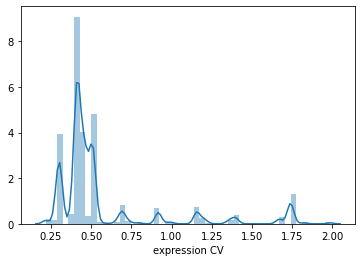

In [25]:
#plot all promoter distribution of TF CV values
all_prom_distribution(Czechowski_genetypes, 'expression_CV', 'expression CV', 'Czechowski_openchrom_expressionCV')

## the CV values seem to mainly have low CVs so tend towards constitutive as in Czechowski et al 2005

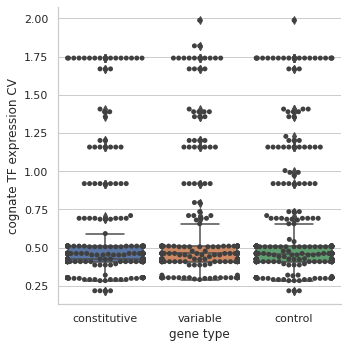

In [26]:
#plot the CV for each promoter gene_type - 400bp rootshootintersect open chromatin individual TF CVs
make_plot(Czechowski_genetypes,'gene_type', 'expression_CV','gene type', 'cognate TF expression CV', 'Czechowski_openchrom_CV', 'box')

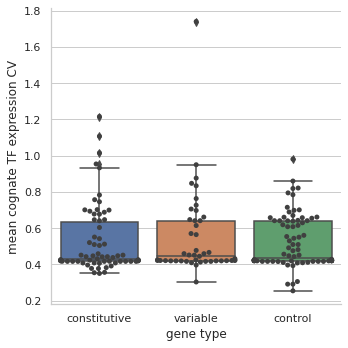

In [27]:
#plot the mean CV for each promoter gene_type - 400bp rootshootintersect open chromatin
make_plot(Czechowski_means_sd_genetype,'gene_type', 'mean_cv','gene type', 'mean cognate TF expression CV', 'Czechowski_openchrom_CV_mean', 'box')

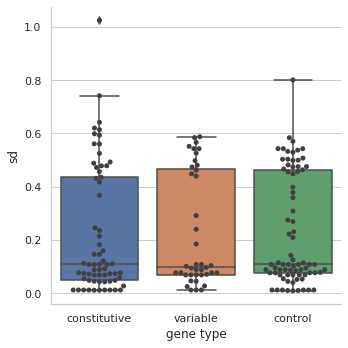

In [28]:
#plot the standard deviation of the CVs of the TFs binding each promoter split into gene_type
make_plot(Czechowski_means_sd_genetype,'gene_type', 'sd','gene type', 'sd', 'Czechowski_openchrom_CV_sd', 'box')

## variable genes seem to have more variation in CV values of TFs that bind them. This makes sense since variable genes seem to have more diverse TFs binding them

In [29]:
# #now plot CV distribution for constitutive genes vs variable genes
#this took too long so commenting out for now
# make_plot(Czechowski_genetypes,'gene_type', 'expression_CV','gene type', 'expression CV', 'Czechowski_CV', 'box')

In [30]:
def test_normality(df,dependent_variable, between):
    """test normality of data categories"""
    #find gene_type categories
    pd.Categorical(df[between])
    names = df[between].unique()
    #Test normality
    #returns test statistic, p-value
    for name in names:
        print('{}: {}'.format(name, stats.shapiro(df[dependent_variable][df[between] == name])))

In [31]:
def describe_stats(df,dependent_variable, between):
    """return descriptve statistics"""
    return df.groupby([between])[dependent_variable].describe()

In [32]:
def variance(df, dependent_variable, between):
    """test variance of data categories"""
    #find gene_type categories
    pd.Categorical(df[between])
    names = df[between].unique()
    #test variance    
    return stats.levene(df[dependent_variable][df[between] == names[0]], 
               df[dependent_variable][df[between] == names[1]], 
               df[dependent_variable][df[between] == names[2]])

In [33]:
def kruskal_test(df,dependent_variable,between):
    """Do Kruskal-Wallis analysis"""
    #Kruskal-Wallis one way analysis of variance
    return kruskal(data=df, dv=dependent_variable, between=between)
    

In [34]:
def dunn_posthoc_test(df,dependent_variable, between):
    """dunn_posthoc tests with bonferroni multiple correction"""
    return sp.posthoc_dunn(df, val_col=dependent_variable, group_col=between, p_adjust='bonferroni')

In [35]:
Czechowski_genetypes

,promoter_AGI,gene_type,chr,start,stop,name_rep,score,strand,p-value,q-value,...,TF_family,TF_AGI,rank,probe_id,expression_mean,expression_SD,expression_CV,proportion_of_values_present_in_mas5,presence_in_araport11,constitutive_in_araport11
0,AT4G34270,constitutive,4.0,16406492.0,16406522.0,BBRBPC_tnt.BPC5_col_a,-48.57690,-,7.390000e-05,0.03860,...,BBRBPC,AT4G38910,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AT4G34270,constitutive,4.0,16406500.0,16406521.0,ND_tnt.FRS9_col_a,5.68254,+,2.530000e-05,0.02030,...,ND,AT4G38170,4890.0,253029_at,69.694512,32.136091,0.461099,83.0,1.0,0.0
2,AT4G34270,constitutive,4.0,16406500.0,16406521.0,BBRBPC_tnt.BPC6_col_a,-2.58904,+,7.530000e-05,0.04780,...,BBRBPC,AT5G42520,1524.0,249199_at,493.182683,149.269860,0.302666,98.0,1.0,0.0
3,AT4G33380,constitutive,4.0,16071850.0,16071871.0,BBRBPC_tnt.BPC6_col_a,1.84932,+,2.060000e-05,0.02030,...,BBRBPC,AT5G42520,1524.0,249199_at,493.182683,149.269860,0.302666,98.0,1.0,0.0
4,AT4G33380,constitutive,4.0,16071850.0,16071865.0,BBRBPC_tnt.BPC1_colamp_a,7.65625,+,3.950000e-05,0.03310,...,BBRBPC,AT2G01930,5762.0,263305_at,181.275661,92.322959,0.509296,100.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1755,AT5G59820,control,5.0,24102802.0,24102826.0,BBRBPC_tnt.BPC1_col_a,-0.06250,-,4.740000e-05,0.02530,...,BBRBPC,AT2G01930,5762.0,263305_at,181.275661,92.322959,0.509296,100.0,1.0,0.0
1756,AT5G59820,control,5.0,24102807.0,24102826.0,C2H2_tnt.TF3A_col_a,10.12780,+,2.900000e-05,0.04030,...,C2H2,AT1G72050,3917.0,256344_at,432.292941,176.708645,0.408771,98.0,1.0,0.0
1757,AT5G59820,control,5.0,24102807.0,24102828.0,C2C2dof_tnt.OBP3_col_a,13.10940,+,1.530000e-05,0.03740,...,C2C2DOF,AT3G55370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1758,AT5G59820,control,5.0,24102997.0,24103016.0,ABI3VP1_tnt.VRN1_colamp_a,8.42466,-,7.270000e-05,0.03460,...,ABI3VP1,AT3G18990,4219.0,256944_at,336.280254,142.874959,0.424869,98.0,1.0,0.0


In [36]:
#rename df for easier analysis
df = Czechowski_means_sd_genetype
between_variable = 'gene_type'
dependent_variable = 'mean_cv'

In [37]:
test_normality(df,dependent_variable,between_variable)

constitutive: ShapiroResult(statistic=0.7433352470397949, pvalue=9.761222941051528e-10)
variable: ShapiroResult(statistic=0.6529377102851868, pvalue=4.639418627050418e-09)
control: ShapiroResult(statistic=0.8821085095405579, pvalue=1.8092165419147932e-06)


## not normal

In [38]:
variance(df, dependent_variable,between_variable)

LeveneResult(statistic=0.33383030424156557, pvalue=0.7165858845766222)

### fail to reject null hypothesis that variances are equal

In [39]:
#descriptive stats
describe_stats(df, dependent_variable,between_variable)

,count,mean,std,min,25%,50%,75%,max
gene_type,,,,,,,,
constitutive,70.0,0.524734,0.185775,0.349755,0.416223,0.428025,0.630990,1.215566
control,82.0,0.516357,0.143659,0.253779,0.419046,0.435178,0.639713,0.980453
variable,45.0,0.550546,0.238331,0.302666,0.419046,0.444540,0.640880,1.739770


In [40]:
kruskal_test(df, dependent_variable,between_variable)

,Source,ddof1,H,p-unc
Kruskal,gene_type,2,0.869928,0.647288


In [41]:
# no significant difference in CV values between constitutive and variable or control 400bp promoters

In [42]:
dunn_posthoc_test(df, dependent_variable,between_variable)

,constitutive,control,variable
constitutive,-1.0,1.0,1.0
control,1.0,-1.0,1.0
variable,1.0,1.0,-1.0


In [43]:
## test to see if difference in standard_deviation between CV values of TFs binding each promoter for each promoter gene type

In [44]:
#rename df for easier analysis
df = Czechowski_means_sd_genetype
between_variable = 'gene_type'
dependent_variable = 'sd'

In [45]:
test_normality(df,dependent_variable,between_variable)

constitutive: ShapiroResult(statistic=nan, pvalue=1.0)
variable: ShapiroResult(statistic=nan, pvalue=1.0)
control: ShapiroResult(statistic=nan, pvalue=1.0)


In [46]:
#descriptive stats
describe_stats(df, dependent_variable,between_variable)

,count,mean,std,min,25%,50%,75%,max
gene_type,,,,,,,,
constitutive,65.0,0.224028,0.237923,0.011383,0.048631,0.108105,0.435632,1.024733
control,76.0,0.232531,0.208372,0.009360,0.074833,0.108105,0.464073,0.800745
variable,40.0,0.226150,0.211988,0.012227,0.068889,0.099161,0.465330,0.587700


In [47]:
kruskal_test(df, dependent_variable,between_variable)

,Source,ddof1,H,p-unc
Kruskal,gene_type,2,0.489993,0.782707


In [87]:
## no significant difference in TFBS CV sd between the promoter types